In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd

Setting the Seed to make my result reproducible

In [ ]:
device = ('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

'cpu'

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

READING THE DATA SET

In [ ]:
batch_size = 32
transform_train = transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    transforms.Resize((32,32)),
    #torchvision.transforms.RandomResizedCrop(32, scale=(0.08, 1.0),
    #                                         ratio=(3.0/4.0, 4.0/3.0)),
    transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    #torchvision.transforms.ColorJitter(brightness=0.4,
    #                                   contrast=0.4,
    #                                   saturation=0.4),
    # Add random noise
    transforms.ToTensor(),
    # Standardize each channel of the image
    # transforms.Normalize([0.485, 0.456, 0.406],
    #                                  [0.229, 0.224, 0.225])
            transforms.Normalize([0.6939, 0.5496, 0.5303],
                                     [0.1225, 0.1382, 0.1509])
   ])

transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    # Crop a 224 x 224 square area from the center of the image
    #torchvision.transforms.CenterCrop(32),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406],
    #                                  [0.229, 0.224, 0.225])
        transforms.Normalize([0.6939, 0.5496, 0.5303],
                                     [0.1225, 0.1382, 0.1509])
   ])



. The dataset consists of 10,410 dermoscopic images of skin lesions, with labels for seven different diagnostic categories. We preprocess the dataset using PyTorch's transforms module by resizing the images to 224x224 pixels and normalizing them with mean and standard deviation values of [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225], respectively. We also remove duplicates using DupGuru.

We split the dataset into training, validation, and testing sets, with 60 percent of the images used for training, 20 percent for validation, and 20 percent  for testing.

Calculated means: tensor([0.6939, 0.5496, 0.5303])
Calculated stds: tensor([0.1225, 0.1382, 0.1509])

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [ ]:
data_dir = '/Users/macbook/Downloads/ISIC_balanced_split'


train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test) for folder in ['valid', 'ISIC2017_test']]

In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

Checking for mean and Standard deviation so I can replace the values in transform. This will normalize and improve the work.

In [ ]:
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_ds:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_ds)
stds /= len(train_ds)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.6939, 0.5496, 0.5303])
Calculated stds: tensor([0.1225, 0.1382, 0.1509])


Show image

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

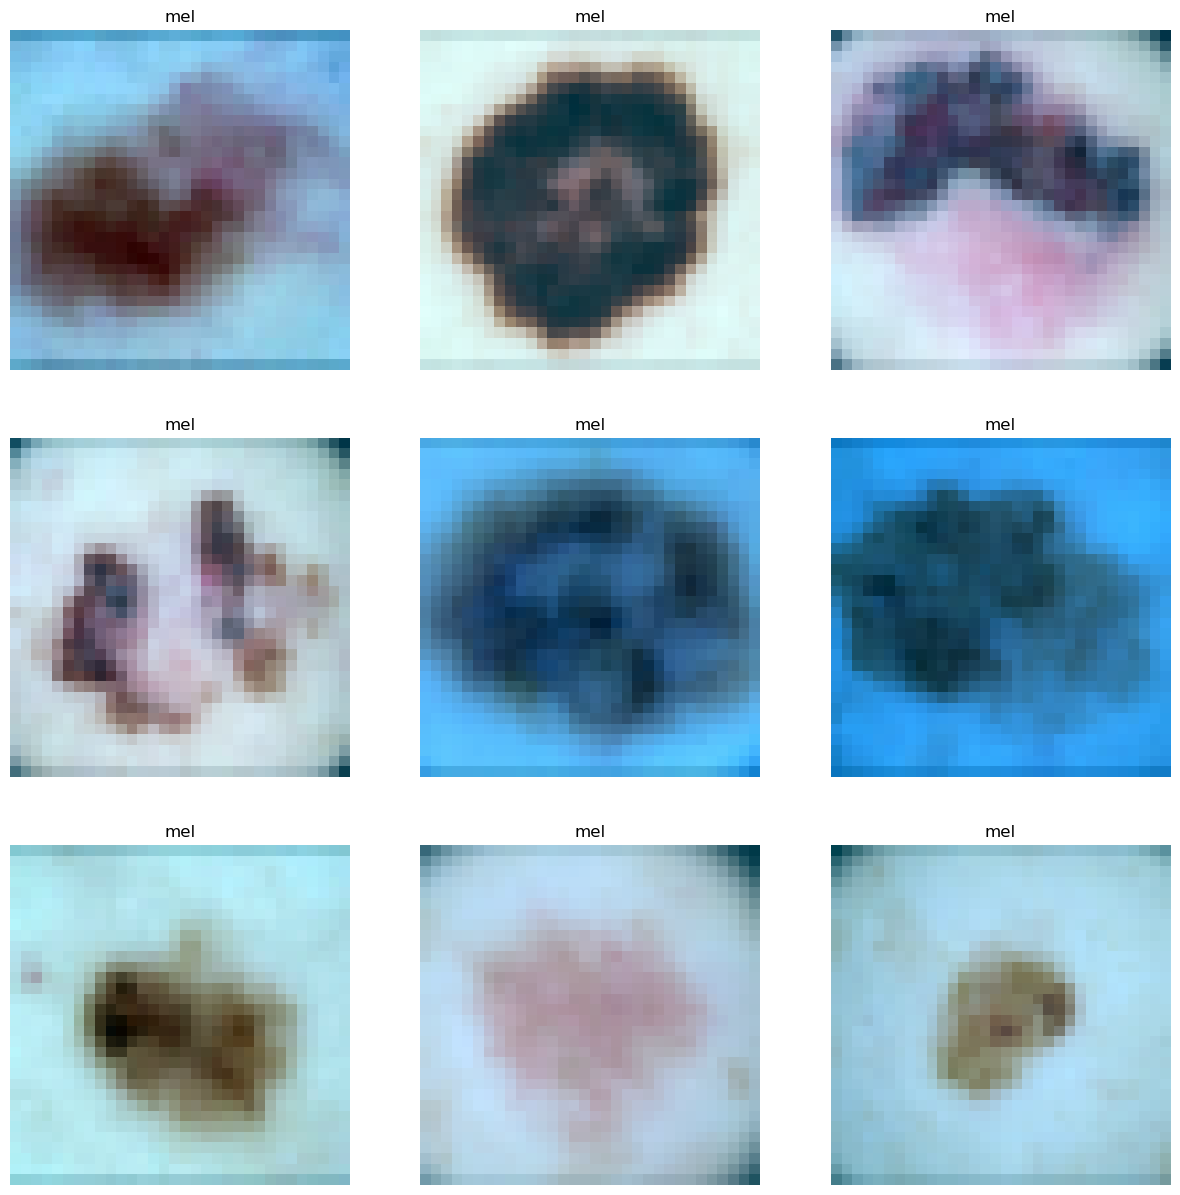

In [ ]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in
                           [train_ds[i] for i in range(N_IMAGES)]])

classes = train_ds.classes

plot_images(images, labels, classes)

DEFINING THE FIRST MODEL

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [ ]:
pretrained_model = models.resnet50(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(train_ds.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,512,130 trainable parameters


TRAINING THE FIRST MODEL AND SETTING THE HYPERPARAMETERS

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [ ]:
EPOCHS = 100
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

PLOT A GRAPH FOR THE ABOVE


Running deep learning models on 100 epochs

In [ ]:
best_valid_loss = float('inf')
best_epoch = 0
best_acc_1 = 0.0
best_acc_5 = 0.0
best_metrics = {'epoch': best_epoch, 'valid_loss': best_valid_loss, 'valid_acc_1': best_acc_1, 'valid_acc_5': best_acc_5}

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

    if valid_loss < best_metrics['valid_loss']:
        best_metrics['epoch'] = epoch + 1
        best_metrics['valid_loss'] = valid_loss
        best_metrics['valid_acc_1'] = valid_acc_1
        best_metrics['valid_acc_5'] = valid_acc_5
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print(f'Best epoch: {best_metrics["epoch"]} | Best Valid Loss: {best_metrics["valid_loss"]:.3f} | '
      f'Best Valid Acc @1: {best_metrics["valid_acc_1"]*100:6.2f}% | Best Valid Acc @5: {best_metrics["valid_acc_5"]*100:6.2f}%')


Epoch: 01 | Epoch Time: 2m 17s
	Train Loss: 0.541 | Train Acc @1:  71.95% | Train Acc @5: 100.00%
	Valid Loss: 0.508 | Valid Acc @1:  76.02% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 2m 5s
	Train Loss: 0.449 | Train Acc @1:  78.27% | Train Acc @5: 100.00%
	Valid Loss: 0.449 | Valid Acc @1:  79.10% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 2m 13s
	Train Loss: 0.422 | Train Acc @1:  80.10% | Train Acc @5: 100.00%
	Valid Loss: 0.465 | Valid Acc @1:  78.33% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 2m 18s
	Train Loss: 0.394 | Train Acc @1:  81.75% | Train Acc @5: 100.00%
	Valid Loss: 0.434 | Valid Acc @1:  80.02% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 2m 21s
	Train Loss: 0.363 | Train Acc @1:  83.20% | Train Acc @5: 100.00%
	Valid Loss: 0.431 | Valid Acc @1:  80.69% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 2m 34s
	Train Loss: 0.334 | Train Acc @1:  84.86% | Train Acc @5: 100.00%
	Valid Loss: 0.479 | Valid Acc @1:  79.46% | Valid Acc @5: 100.00%
Epoch: 07 |

In [ ]:
best_metrics

{'epoch': 5,
 'valid_loss': 0.43063640618910554,
 'valid_acc_1': 0.8068647540983607,
 'valid_acc_5': 1.0}

model with early stopping

In [ ]:
best_valid_loss = float('inf')
patience = 5
counter = 0

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'resnet_early_stopping.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')


Epoch: 01 | Epoch Time: 2m 20s
	Train Loss: 0.544 | Train Acc @1:  71.82% | Train Acc @5: 100.00%
	Valid Loss: 0.496 | Valid Acc @1:  76.38% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 2m 19s
	Train Loss: 0.455 | Train Acc @1:  77.35% | Train Acc @5: 100.00%
	Valid Loss: 0.453 | Valid Acc @1:  78.33% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 2m 20s
	Train Loss: 0.418 | Train Acc @1:  80.17% | Train Acc @5: 100.00%
	Valid Loss: 0.446 | Valid Acc @1:  78.79% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 2m 19s
	Train Loss: 0.393 | Train Acc @1:  81.86% | Train Acc @5: 100.00%
	Valid Loss: 0.449 | Valid Acc @1:  79.76% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 2m 21s
	Train Loss: 0.370 | Train Acc @1:  82.82% | Train Acc @5: 100.00%
	Valid Loss: 0.435 | Valid Acc @1:  80.53% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 2m 18s
	Train Loss: 0.347 | Train Acc @1:  84.60% | Train Acc @5: 100.00%
	Valid Loss: 0.463 | Valid Acc @1:  80.48% | Valid Acc @5: 100.00%
Epoch: 07 

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iter)

In [ ]:
test = pd.read_csv('/Users/macbook/Downloads/ISIC_balanced_split/ISIC2017_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

In [ ]:
with open('/Users/macbook/Downloads/ISIC_balanced_split/predicted.csv', 'w') as f:

    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')

    for i, output in zip(test['id'], probs.numpy()):

      f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) +'\n')

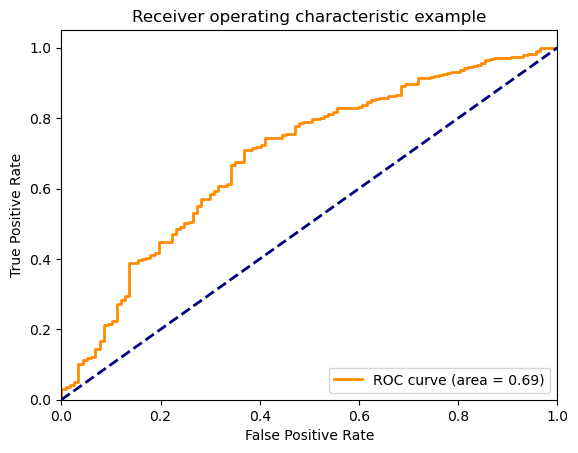

/var/folders/d9/1sn3xmzd49v653mvdfkrs_f80000gn/T/ipykernel_12354/2203387860.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


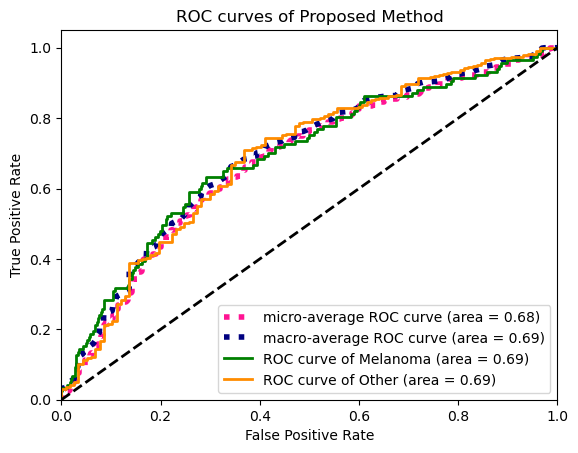

In [ ]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
#change to OneVsOneClassifier for generalized AUC
#from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of Melanoma (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of Other (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
# plt.plot(fpr[2], tpr[2], color='red', lw=lw,
#          label='ROC curve of third class (area = {1:0.2f})'
#          ''.format(1, roc_auc[2]))

# plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
#          label='ROC curve of fourth class (area = {1:0.2f})'
#          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[ 77  40]
 [178 305]]
[0 1]
[117 483]
[[117. 117.]
 [483. 483.]]


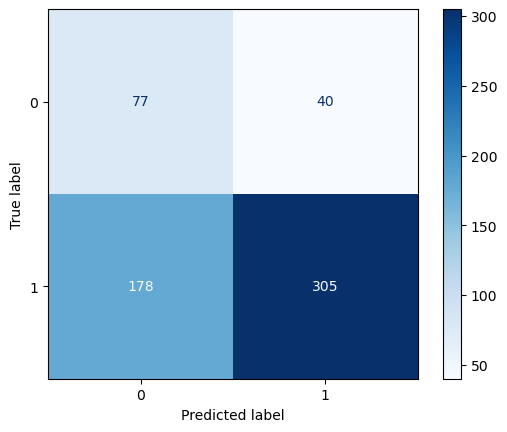

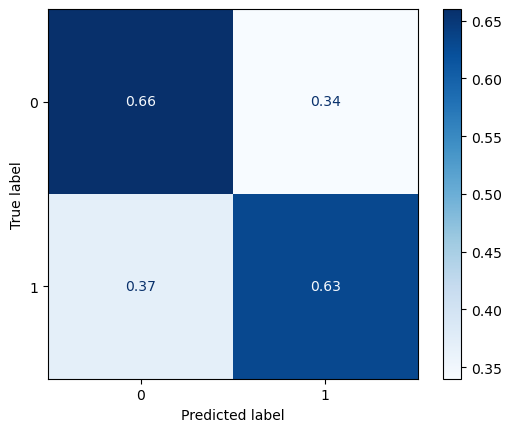

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 117
divisor[1][:] = 483
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_class, pred_class))

              precision    recall  f1-score   support

           0       0.30      0.66      0.41       117
           1       0.88      0.63      0.74       483

    accuracy                           0.64       600
   macro avg       0.59      0.64      0.58       600
weighted avg       0.77      0.64      0.67       600



In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

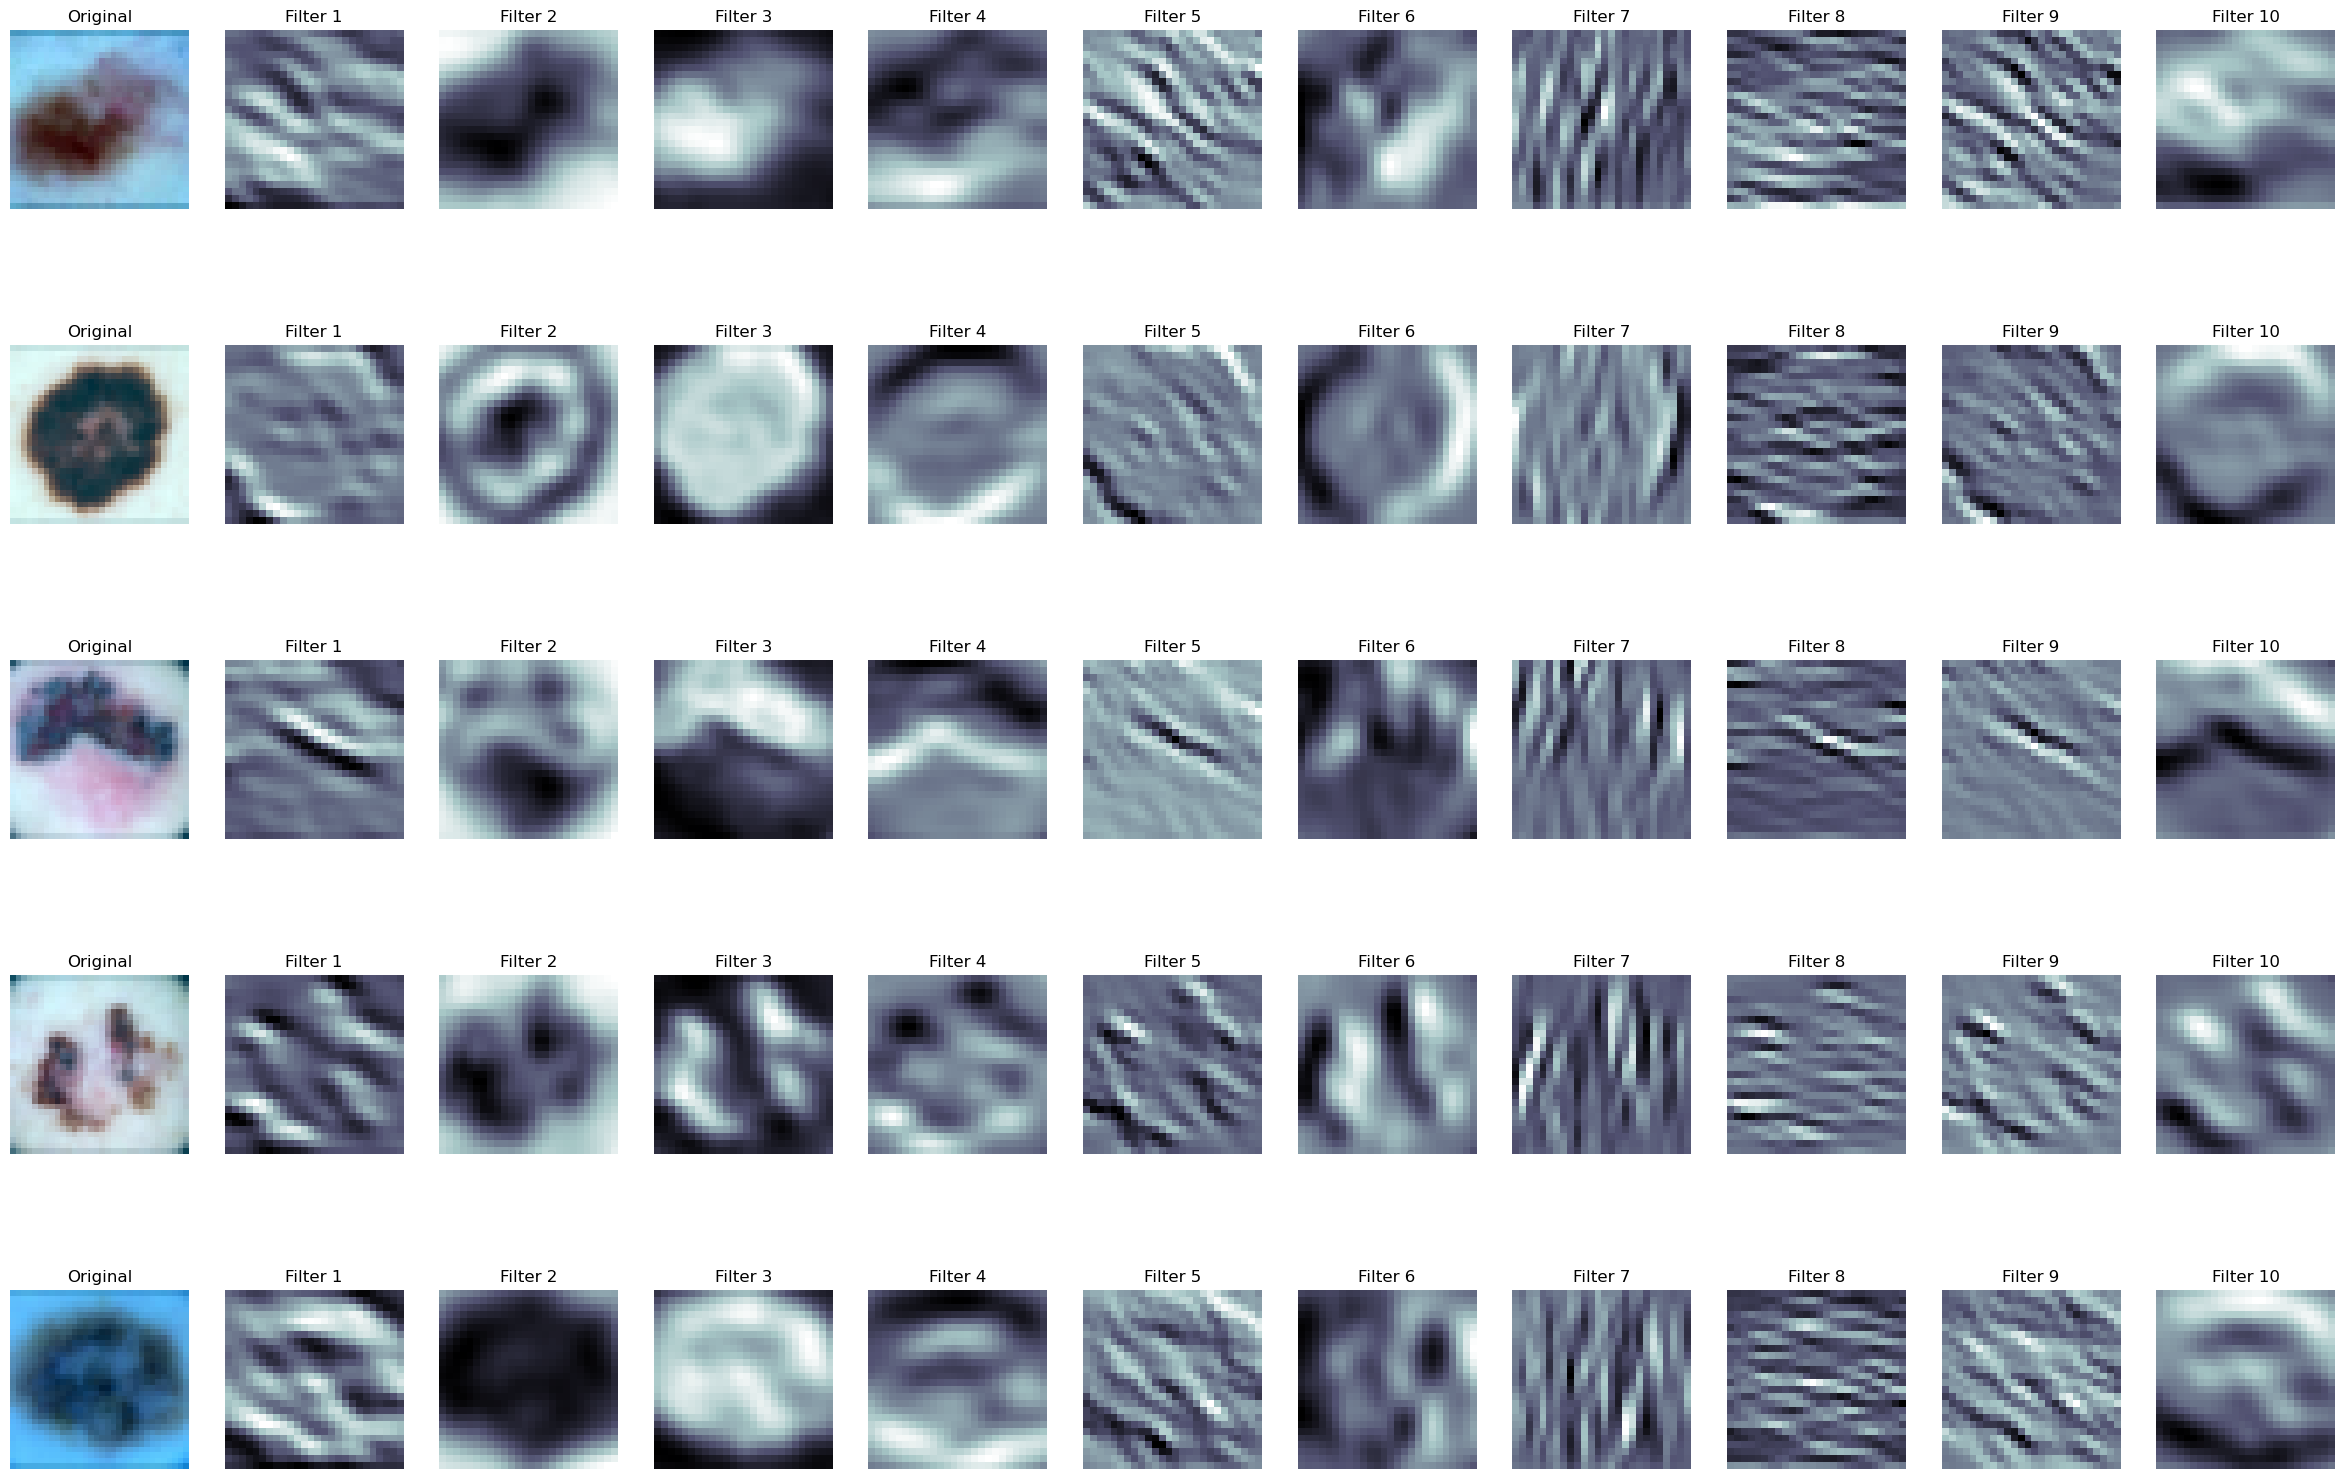

In [ ]:
N_IMAGES = 5
N_FILTERS = 10

images = [image for image, label in [train_ds[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

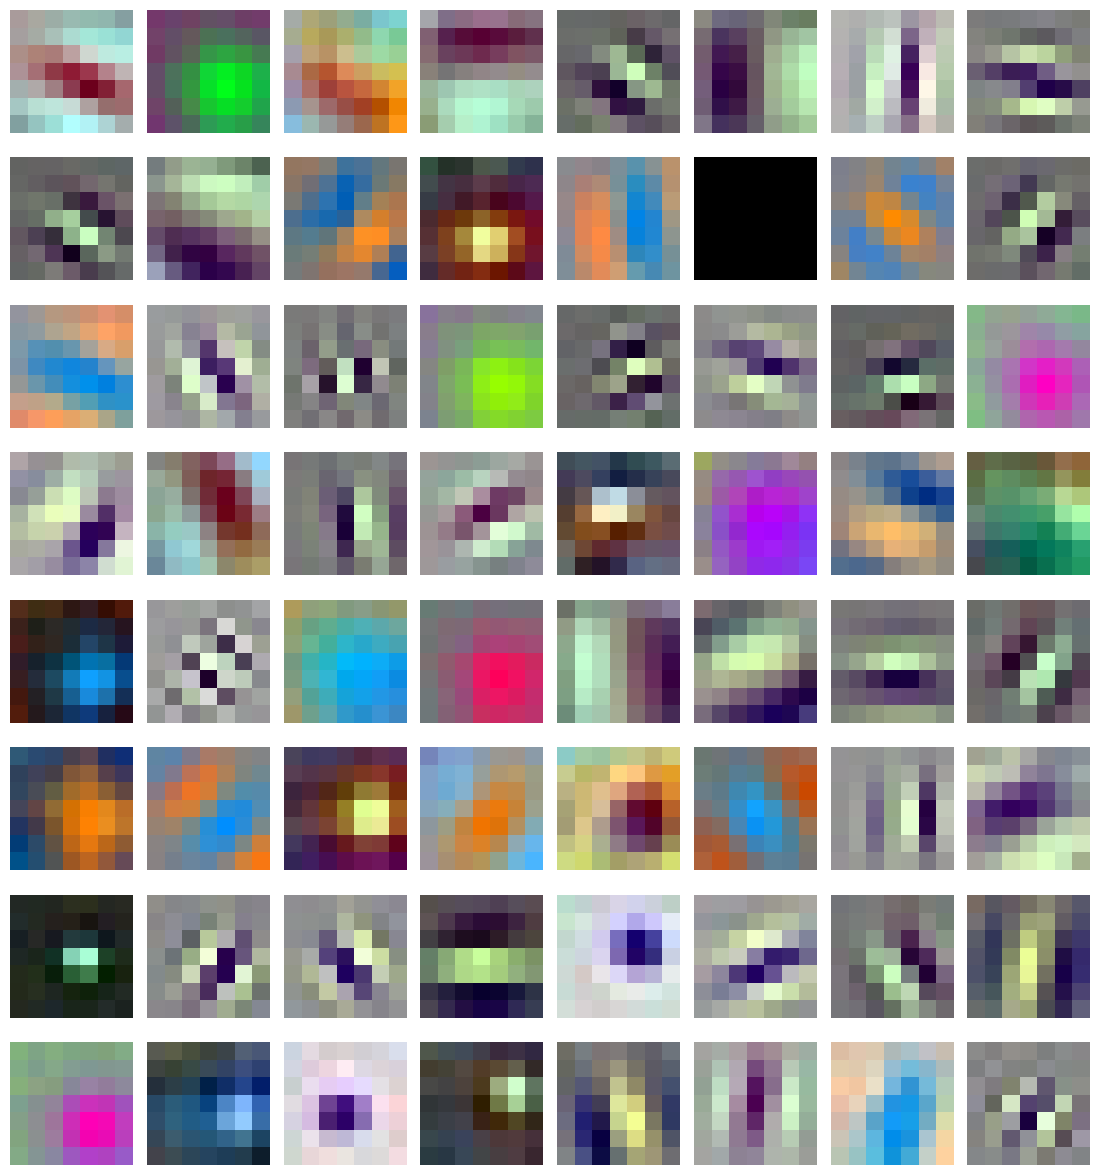

In [ ]:
plot_filters(filters)

USING AlexNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
import copy

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Define the CNN - this  will focus on AlexNet.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

adjusting the number of classes

In [ ]:
OUTPUT_DIM = 2

model = AlexNet(OUTPUT_DIM)

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

This is to display the number of trainable parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,239,490 trainable parameters


Setting the hyperparameters and train the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=CHOSE_LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Training the model

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs



In [ ]:
EPOCHS = 100

# keeping-track-of-losses
train_losses = []
valid_losses = []

best_valid_loss = float('inf')
best_epoch = 0
best_acc = 0.0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        best_acc = valid_acc
        torch.save(model.state_dict(), '1best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

best_results = {'epoch': best_epoch+1, 'accuracy': best_acc, 'loss': best_valid_loss}
print(f'Best epoch: {best_results["epoch"]} | Accuracy: {best_results["accuracy"]*100:.2f}% | Loss: {best_results["loss"]:.3f}')


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 22s
	Train Loss: 1.436 | Train Acc: 73.01%
	 Val. Loss: 0.487 |  Val. Acc: 77.00%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 13s
	Train Loss: 0.486 | Train Acc: 76.38%
	 Val. Loss: 0.470 |  Val. Acc: 76.95%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 22s
	Train Loss: 0.469 | Train Acc: 77.18%
	 Val. Loss: 0.463 |  Val. Acc: 76.38%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 33s
	Train Loss: 0.459 | Train Acc: 77.92%
	 Val. Loss: 0.468 |  Val. Acc: 75.87%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 25s
	Train Loss: 0.450 | Train Acc: 78.05%
	 Val. Loss: 0.469 |  Val. Acc: 77.41%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 28s
	Train Loss: 0.436 | Train Acc: 79.25%
	 Val. Loss: 0.463 |  Val. Acc: 77.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 34s
	Train Loss: 0.428 | Train Acc: 79.97%
	 Val. Loss: 0.476 |  Val. Acc: 76.13%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 34s
	Train Loss: 0.428 | Train Acc: 79.58%
	 Val. Loss: 0.454 |  Val. Acc: 77.87%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 34s
	Train Loss: 0.417 | Train Acc: 80.17%
	 Val. Loss: 0.456 |  Val. Acc: 77.72%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 35s
	Train Loss: 0.411 | Train Acc: 80.79%
	 Val. Loss: 0.446 |  Val. Acc: 78.64%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 34s
	Train Loss: 0.400 | Train Acc: 81.03%
	 Val. Loss: 0.458 |  Val. Acc: 79.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 38s
	Train Loss: 0.403 | Train Acc: 81.43%
	 Val. Loss: 0.444 |  Val. Acc: 78.02%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 45s
	Train Loss: 0.393 | Train Acc: 81.58%
	 Val. Loss: 0.444 |  Val. Acc: 79.20%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 42s
	Train Loss: 0.388 | Train Acc: 82.16%
	 Val. Loss: 0.453 |  Val. Acc: 78.12%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 42s
	Train Loss: 0.379 | Train Acc: 82.41%
	 Val. Loss: 0.489 |  Val. Acc: 78.28%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 53s
	Train Loss: 0.369 | Train Acc: 82.97%
	 Val. Loss: 0.455 |  Val. Acc: 79.30%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 1m 37s
	Train Loss: 0.369 | Train Acc: 83.52%
	 Val. Loss: 0.520 |  Val. Acc: 77.20%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 34s
	Train Loss: 0.354 | Train Acc: 83.30%
	 Val. Loss: 0.459 |  Val. Acc: 77.36%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 1m 33s
	Train Loss: 0.346 | Train Acc: 84.22%
	 Val. Loss: 0.541 |  Val. Acc: 78.79%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 33s
	Train Loss: 0.343 | Train Acc: 84.54%
	 Val. Loss: 0.454 |  Val. Acc: 78.89%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 1m 32s
	Train Loss: 0.343 | Train Acc: 84.80%
	 Val. Loss: 0.497 |  Val. Acc: 78.28%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 32s
	Train Loss: 0.320 | Train Acc: 85.29%
	 Val. Loss: 0.460 |  Val. Acc: 77.82%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 1m 35s
	Train Loss: 0.306 | Train Acc: 86.58%
	 Val. Loss: 0.561 |  Val. Acc: 78.33%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 1m 37s
	Train Loss: 0.291 | Train Acc: 87.09%
	 Val. Loss: 0.544 |  Val. Acc: 77.41%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 1m 36s
	Train Loss: 0.290 | Train Acc: 87.50%
	 Val. Loss: 0.491 |  Val. Acc: 77.66%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 1m 35s
	Train Loss: 0.284 | Train Acc: 88.20%
	 Val. Loss: 0.656 |  Val. Acc: 77.87%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 1m 33s
	Train Loss: 0.264 | Train Acc: 88.76%
	 Val. Loss: 0.705 |  Val. Acc: 77.92%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 1m 36s
	Train Loss: 0.242 | Train Acc: 89.54%
	 Val. Loss: 0.585 |  Val. Acc: 78.18%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 1m 35s
	Train Loss: 0.251 | Train Acc: 89.53%
	 Val. Loss: 0.582 |  Val. Acc: 77.82%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 1m 36s
	Train Loss: 0.247 | Train Acc: 89.73%
	 Val. Loss: 0.549 |  Val. Acc: 77.15%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 1m 35s
	Train Loss: 0.221 | Train Acc: 90.87%
	 Val. Loss: 0.776 |  Val. Acc: 78.38%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 1m 36s
	Train Loss: 0.205 | Train Acc: 91.28%
	 Val. Loss: 0.885 |  Val. Acc: 77.51%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 1m 35s
	Train Loss: 0.213 | Train Acc: 91.26%
	 Val. Loss: 0.699 |  Val. Acc: 77.15%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 1m 37s
	Train Loss: 0.198 | Train Acc: 92.08%
	 Val. Loss: 0.916 |  Val. Acc: 77.46%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 1m 35s
	Train Loss: 0.201 | Train Acc: 92.03%
	 Val. Loss: 0.804 |  Val. Acc: 77.82%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 1m 37s
	Train Loss: 0.185 | Train Acc: 92.97%
	 Val. Loss: 0.754 |  Val. Acc: 77.82%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 1m 37s
	Train Loss: 0.171 | Train Acc: 93.30%
	 Val. Loss: 0.611 |  Val. Acc: 76.84%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 1m 36s
	Train Loss: 0.158 | Train Acc: 93.79%
	 Val. Loss: 0.757 |  Val. Acc: 77.36%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 1m 36s
	Train Loss: 0.174 | Train Acc: 93.04%
	 Val. Loss: 1.067 |  Val. Acc: 76.79%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 1m 38s
	Train Loss: 0.145 | Train Acc: 94.17%
	 Val. Loss: 1.024 |  Val. Acc: 77.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 1m 37s
	Train Loss: 0.150 | Train Acc: 94.31%
	 Val. Loss: 1.153 |  Val. Acc: 77.61%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 1m 36s
	Train Loss: 0.142 | Train Acc: 94.94%
	 Val. Loss: 0.653 |  Val. Acc: 77.46%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 1m 37s
	Train Loss: 0.169 | Train Acc: 93.84%
	 Val. Loss: 1.280 |  Val. Acc: 76.69%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 1m 39s
	Train Loss: 0.136 | Train Acc: 94.89%
	 Val. Loss: 1.442 |  Val. Acc: 77.61%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 1m 37s
	Train Loss: 0.131 | Train Acc: 95.22%
	 Val. Loss: 1.061 |  Val. Acc: 77.77%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 1m 37s
	Train Loss: 0.103 | Train Acc: 96.31%
	 Val. Loss: 2.089 |  Val. Acc: 77.77%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 1m 37s
	Train Loss: 0.123 | Train Acc: 95.42%
	 Val. Loss: 1.028 |  Val. Acc: 77.61%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 1m 37s
	Train Loss: 0.114 | Train Acc: 95.68%
	 Val. Loss: 1.148 |  Val. Acc: 76.38%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 1m 37s
	Train Loss: 0.118 | Train Acc: 95.88%
	 Val. Loss: 1.031 |  Val. Acc: 76.69%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 1m 37s
	Train Loss: 0.141 | Train Acc: 95.34%
	 Val. Loss: 0.589 |  Val. Acc: 75.61%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 51 | Epoch Time: 1m 38s
	Train Loss: 0.126 | Train Acc: 95.77%
	 Val. Loss: 1.206 |  Val. Acc: 78.02%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 1m 37s
	Train Loss: 0.130 | Train Acc: 95.18%
	 Val. Loss: 1.520 |  Val. Acc: 76.64%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 53 | Epoch Time: 1m 38s
	Train Loss: 0.114 | Train Acc: 95.99%
	 Val. Loss: 0.890 |  Val. Acc: 76.38%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 1m 37s
	Train Loss: 0.114 | Train Acc: 96.14%
	 Val. Loss: 1.664 |  Val. Acc: 78.12%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 55 | Epoch Time: 1m 38s
	Train Loss: 0.090 | Train Acc: 96.65%
	 Val. Loss: 1.456 |  Val. Acc: 77.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 1m 39s
	Train Loss: 0.105 | Train Acc: 96.45%
	 Val. Loss: 1.360 |  Val. Acc: 77.20%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 57 | Epoch Time: 1m 38s
	Train Loss: 0.122 | Train Acc: 95.80%
	 Val. Loss: 1.512 |  Val. Acc: 79.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 1m 39s
	Train Loss: 0.136 | Train Acc: 95.75%
	 Val. Loss: 0.930 |  Val. Acc: 78.28%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 59 | Epoch Time: 1m 40s
	Train Loss: 0.099 | Train Acc: 96.52%
	 Val. Loss: 1.342 |  Val. Acc: 78.69%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 1m 37s
	Train Loss: 0.101 | Train Acc: 96.67%
	 Val. Loss: 1.056 |  Val. Acc: 78.59%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 61 | Epoch Time: 1m 36s
	Train Loss: 0.078 | Train Acc: 97.28%
	 Val. Loss: 1.266 |  Val. Acc: 77.56%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 62 | Epoch Time: 1m 39s
	Train Loss: 0.079 | Train Acc: 97.14%
	 Val. Loss: 1.248 |  Val. Acc: 76.84%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 63 | Epoch Time: 1m 39s
	Train Loss: 0.084 | Train Acc: 97.32%
	 Val. Loss: 1.805 |  Val. Acc: 77.25%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 64 | Epoch Time: 1m 39s
	Train Loss: 0.064 | Train Acc: 97.79%
	 Val. Loss: 2.392 |  Val. Acc: 77.00%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 65 | Epoch Time: 1m 38s
	Train Loss: 0.083 | Train Acc: 97.05%
	 Val. Loss: 1.728 |  Val. Acc: 76.64%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 66 | Epoch Time: 1m 38s
	Train Loss: 0.083 | Train Acc: 97.37%
	 Val. Loss: 0.752 |  Val. Acc: 77.25%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 67 | Epoch Time: 1m 39s
	Train Loss: 0.064 | Train Acc: 97.87%
	 Val. Loss: 1.602 |  Val. Acc: 77.72%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 68 | Epoch Time: 1m 47s
	Train Loss: 0.059 | Train Acc: 98.14%
	 Val. Loss: 1.275 |  Val. Acc: 78.38%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 69 | Epoch Time: 2m 0s
	Train Loss: 0.065 | Train Acc: 97.70%
	 Val. Loss: 1.748 |  Val. Acc: 77.25%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 70 | Epoch Time: 1m 49s
	Train Loss: 0.089 | Train Acc: 97.24%
	 Val. Loss: 1.123 |  Val. Acc: 76.18%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 71 | Epoch Time: 1m 49s
	Train Loss: 0.063 | Train Acc: 97.82%
	 Val. Loss: 1.335 |  Val. Acc: 78.07%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 72 | Epoch Time: 1m 51s
	Train Loss: 0.097 | Train Acc: 96.84%
	 Val. Loss: 1.624 |  Val. Acc: 76.38%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 73 | Epoch Time: 1m 50s
	Train Loss: 0.084 | Train Acc: 97.47%
	 Val. Loss: 1.508 |  Val. Acc: 78.43%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 74 | Epoch Time: 1m 49s
	Train Loss: 0.080 | Train Acc: 97.35%
	 Val. Loss: 1.071 |  Val. Acc: 77.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 75 | Epoch Time: 1m 48s
	Train Loss: 0.080 | Train Acc: 97.21%
	 Val. Loss: 1.643 |  Val. Acc: 78.69%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 76 | Epoch Time: 1m 48s
	Train Loss: 0.064 | Train Acc: 98.04%
	 Val. Loss: 1.097 |  Val. Acc: 77.20%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 77 | Epoch Time: 1m 50s
	Train Loss: 0.068 | Train Acc: 97.96%
	 Val. Loss: 1.066 |  Val. Acc: 77.97%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 78 | Epoch Time: 1m 49s
	Train Loss: 0.068 | Train Acc: 97.93%
	 Val. Loss: 1.275 |  Val. Acc: 78.28%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 79 | Epoch Time: 1m 50s
	Train Loss: 0.068 | Train Acc: 97.76%
	 Val. Loss: 1.546 |  Val. Acc: 77.36%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 80 | Epoch Time: 1m 47s
	Train Loss: 0.075 | Train Acc: 97.45%
	 Val. Loss: 1.821 |  Val. Acc: 76.84%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 81 | Epoch Time: 1m 48s
	Train Loss: 0.062 | Train Acc: 98.15%
	 Val. Loss: 1.583 |  Val. Acc: 78.12%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 82 | Epoch Time: 1m 48s
	Train Loss: 0.081 | Train Acc: 97.65%
	 Val. Loss: 1.309 |  Val. Acc: 78.02%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 83 | Epoch Time: 1m 48s
	Train Loss: 0.062 | Train Acc: 98.01%
	 Val. Loss: 1.995 |  Val. Acc: 77.36%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 84 | Epoch Time: 1m 48s
	Train Loss: 0.081 | Train Acc: 97.42%
	 Val. Loss: 0.978 |  Val. Acc: 78.28%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 85 | Epoch Time: 1m 48s
	Train Loss: 0.062 | Train Acc: 98.00%
	 Val. Loss: 1.281 |  Val. Acc: 76.79%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 86 | Epoch Time: 1m 48s
	Train Loss: 0.068 | Train Acc: 98.16%
	 Val. Loss: 1.887 |  Val. Acc: 77.31%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 87 | Epoch Time: 1m 48s
	Train Loss: 0.049 | Train Acc: 98.55%
	 Val. Loss: 2.327 |  Val. Acc: 77.25%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 88 | Epoch Time: 1m 48s
	Train Loss: 0.078 | Train Acc: 97.86%
	 Val. Loss: 1.623 |  Val. Acc: 76.33%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 89 | Epoch Time: 1m 48s
	Train Loss: 0.073 | Train Acc: 97.79%
	 Val. Loss: 1.142 |  Val. Acc: 78.33%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 90 | Epoch Time: 1m 48s
	Train Loss: 0.048 | Train Acc: 98.47%
	 Val. Loss: 2.959 |  Val. Acc: 76.84%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 91 | Epoch Time: 1m 48s
	Train Loss: 0.164 | Train Acc: 95.60%
	 Val. Loss: 1.219 |  Val. Acc: 77.36%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 92 | Epoch Time: 1m 48s
	Train Loss: 0.062 | Train Acc: 97.73%
	 Val. Loss: 1.449 |  Val. Acc: 78.43%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 93 | Epoch Time: 1m 47s
	Train Loss: 0.077 | Train Acc: 97.81%
	 Val. Loss: 2.437 |  Val. Acc: 76.69%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 94 | Epoch Time: 1m 47s
	Train Loss: 0.059 | Train Acc: 98.27%
	 Val. Loss: 1.437 |  Val. Acc: 76.90%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 95 | Epoch Time: 1m 48s
	Train Loss: 0.061 | Train Acc: 98.21%
	 Val. Loss: 1.672 |  Val. Acc: 77.77%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 96 | Epoch Time: 1m 48s
	Train Loss: 0.046 | Train Acc: 98.62%
	 Val. Loss: 2.041 |  Val. Acc: 78.33%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 97 | Epoch Time: 1m 49s
	Train Loss: 0.046 | Train Acc: 98.80%
	 Val. Loss: 2.374 |  Val. Acc: 78.07%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 98 | Epoch Time: 1m 48s
	Train Loss: 0.051 | Train Acc: 98.56%
	 Val. Loss: 2.402 |  Val. Acc: 77.87%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 99 | Epoch Time: 1m 50s
	Train Loss: 0.061 | Train Acc: 98.14%
	 Val. Loss: 2.434 |  Val. Acc: 77.51%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 100 | Epoch Time: 1m 49s
	Train Loss: 0.083 | Train Acc: 97.69%
	 Val. Loss: 0.704 |  Val. Acc: 77.00%
Best epoch: 13 | Accuracy: 79.20% | Loss: 0.444


In [ ]:
EPOCHS = 100
PATIENCE = 5  # number of epochs without improvement to wait before stopping

train_losses = []
valid_losses = []

best_valid_loss = float('inf')
patience_counter = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Alex_early_stopping.pt')
        patience_counter = 0  # reset patience counter on improvement
    else:
        patience_counter += 1  # increase patience counter on no improvement

    if patience_counter >= PATIENCE:
        print(f"Validation loss hasn't improved in {PATIENCE} epochs. Stopping early.")
        break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 11s
	Train Loss: 1.436 | Train Acc: 73.01%
	 Val. Loss: 0.487 |  Val. Acc: 77.00%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 15s
	Train Loss: 0.486 | Train Acc: 76.38%
	 Val. Loss: 0.470 |  Val. Acc: 76.95%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 20s
	Train Loss: 0.469 | Train Acc: 77.18%
	 Val. Loss: 0.463 |  Val. Acc: 76.38%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 26s
	Train Loss: 0.459 | Train Acc: 77.92%
	 Val. Loss: 0.468 |  Val. Acc: 75.87%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 26s
	Train Loss: 0.450 | Train Acc: 78.05%
	 Val. Loss: 0.469 |  Val. Acc: 77.41%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 29s
	Train Loss: 0.436 | Train Acc: 79.25%
	 Val. Loss: 0.463 |  Val. Acc: 77.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 34s
	Train Loss: 0.428 | Train Acc: 79.97%
	 Val. Loss: 0.476 |  Val. Acc: 76.13%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 29s
	Train Loss: 0.428 | Train Acc: 79.58%
	 Val. Loss: 0.454 |  Val. Acc: 77.87%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 32s
	Train Loss: 0.417 | Train Acc: 80.17%
	 Val. Loss: 0.456 |  Val. Acc: 77.72%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 29s
	Train Loss: 0.411 | Train Acc: 80.79%
	 Val. Loss: 0.446 |  Val. Acc: 78.64%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 33s
	Train Loss: 0.400 | Train Acc: 81.03%
	 Val. Loss: 0.458 |  Val. Acc: 79.05%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 30s
	Train Loss: 0.403 | Train Acc: 81.43%
	 Val. Loss: 0.444 |  Val. Acc: 78.02%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 32s
	Train Loss: 0.393 | Train Acc: 81.58%
	 Val. Loss: 0.444 |  Val. Acc: 79.20%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 32s
	Train Loss: 0.388 | Train Acc: 82.16%
	 Val. Loss: 0.453 |  Val. Acc: 78.12%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 43s
	Train Loss: 0.379 | Train Acc: 82.41%
	 Val. Loss: 0.489 |  Val. Acc: 78.28%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 34s
	Train Loss: 0.369 | Train Acc: 82.97%
	 Val. Loss: 0.455 |  Val. Acc: 79.30%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 1m 32s
	Train Loss: 0.369 | Train Acc: 83.52%
	 Val. Loss: 0.520 |  Val. Acc: 77.20%


Training:   0%|          | 0/245 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

Validation loss hasn't improved in 5 epochs. Stopping early.


Plotting Losses

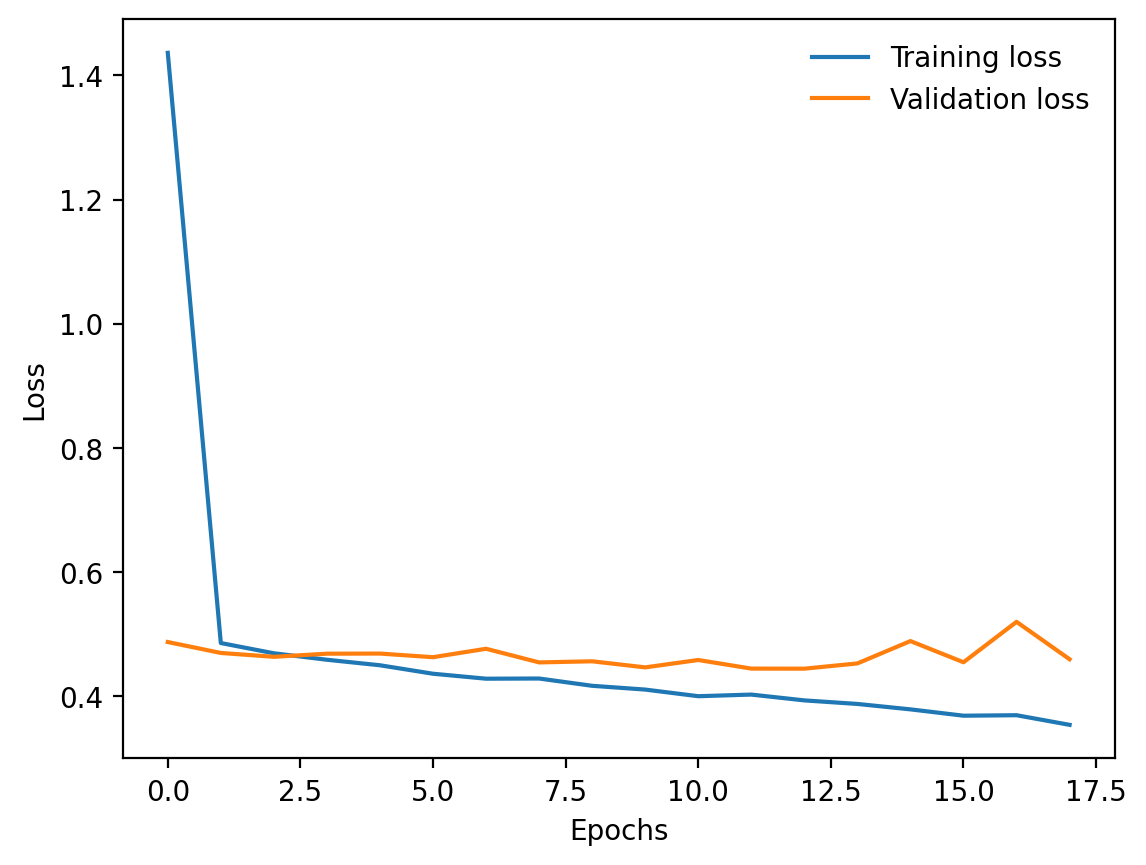

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

Loading the best model

In [ ]:
model.load_state_dict(torch.load('Alex_early_stopping.pt'))

<All keys matched successfully>

In [ ]:
images, labels, probs = get_predictions(model, test_iter, device)

In [ ]:
test = pd.read_csv('/Users/macbook/Downloads/ISIC_balanced_split/ISIC2017_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

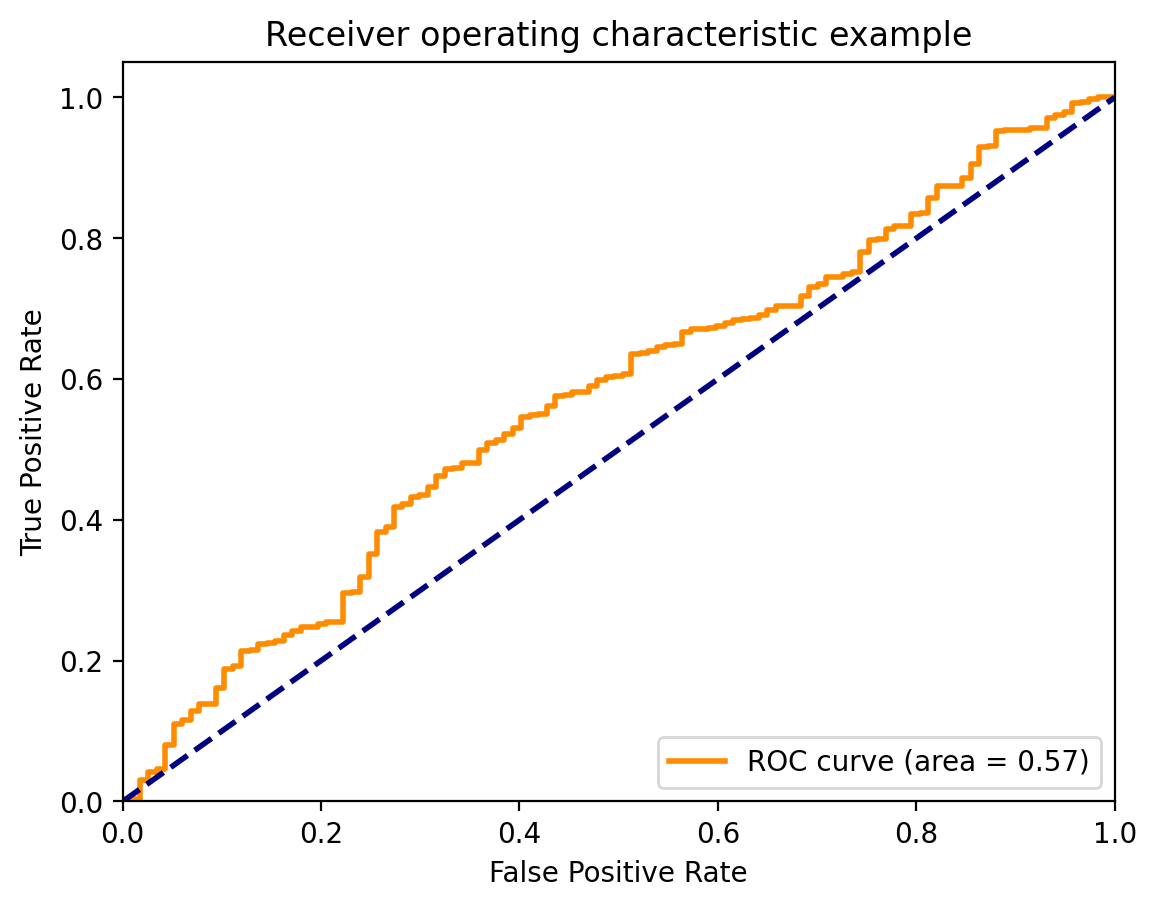

/var/folders/d9/1sn3xmzd49v653mvdfkrs_f80000gn/T/ipykernel_12913/2203387860.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


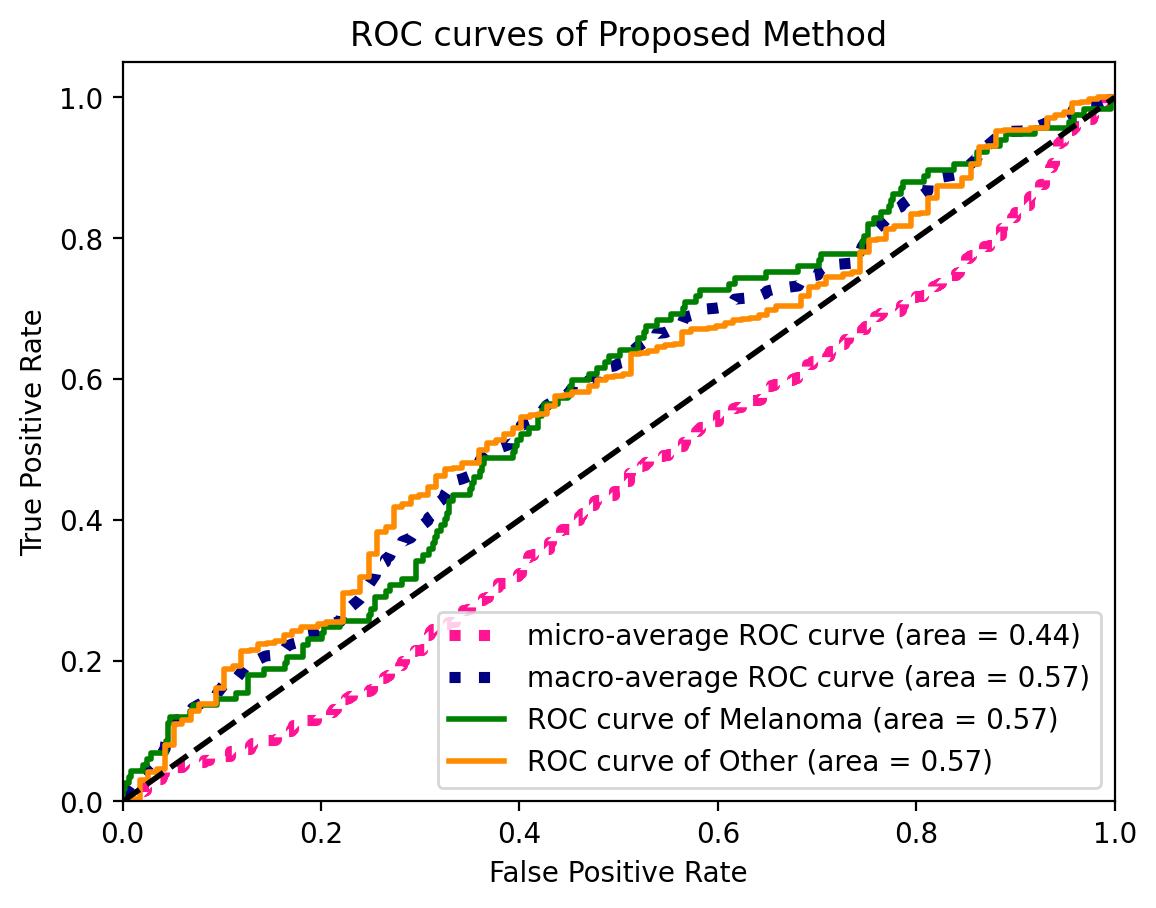

In [ ]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
#change to OneVsOneClassifier for generalized AUC
#from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of Melanoma (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of Other (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
# plt.plot(fpr[2], tpr[2], color='red', lw=lw,
#          label='ROC curve of third class (area = {1:0.2f})'
#          ''.format(1, roc_auc[2]))

# plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
#          label='ROC curve of fourth class (area = {1:0.2f})'
#          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[ 85  32]
 [282 201]]
[0 1]
[117 483]
[[117. 117.]
 [483. 483.]]


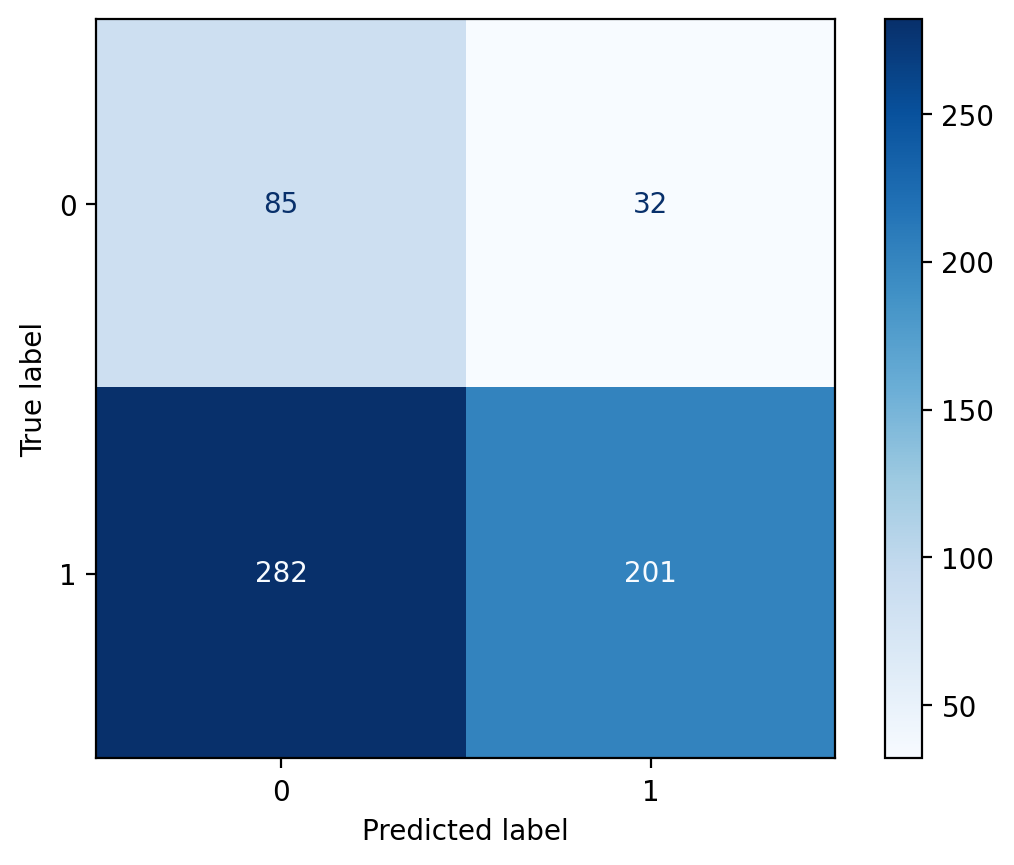

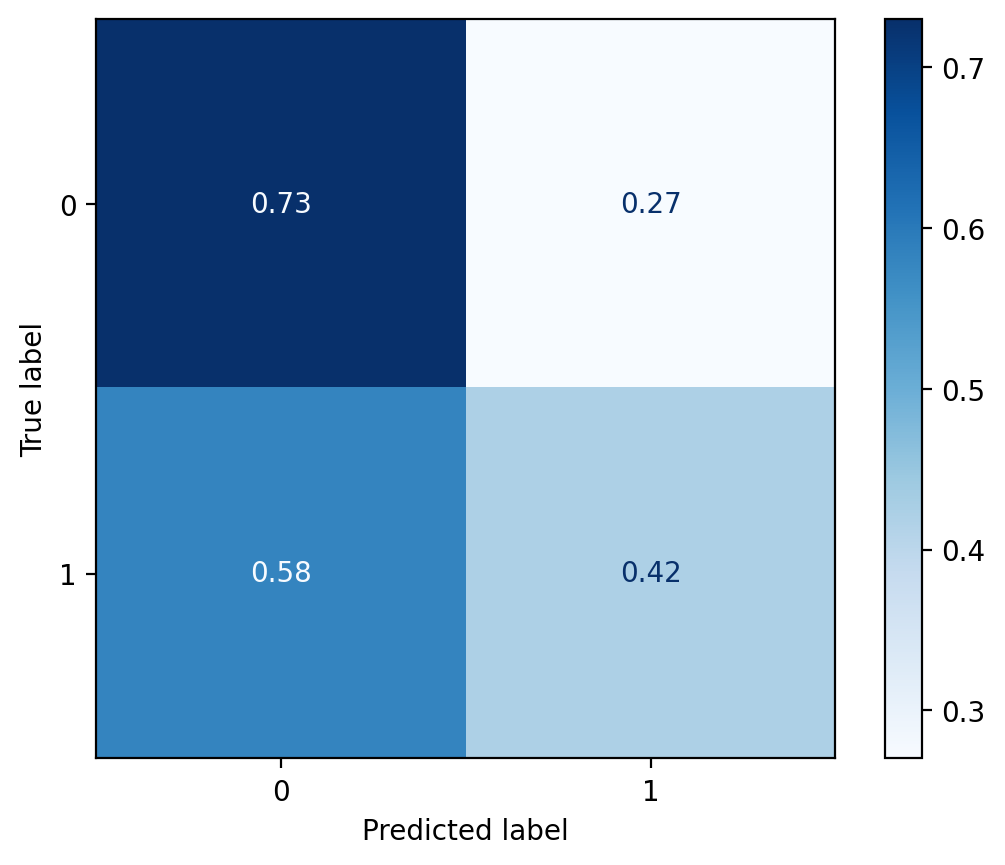

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 117
divisor[1][:] = 483
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_class, pred_class))

              precision    recall  f1-score   support

           0       0.23      0.73      0.35       117
           1       0.86      0.42      0.56       483

    accuracy                           0.48       600
   macro avg       0.55      0.57      0.46       600
weighted avg       0.74      0.48      0.52       600



This is optional visualisation for those who are interested in interpreting their results. MIT License: Copyright (c) 2018 Ben Trevett

In [ ]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

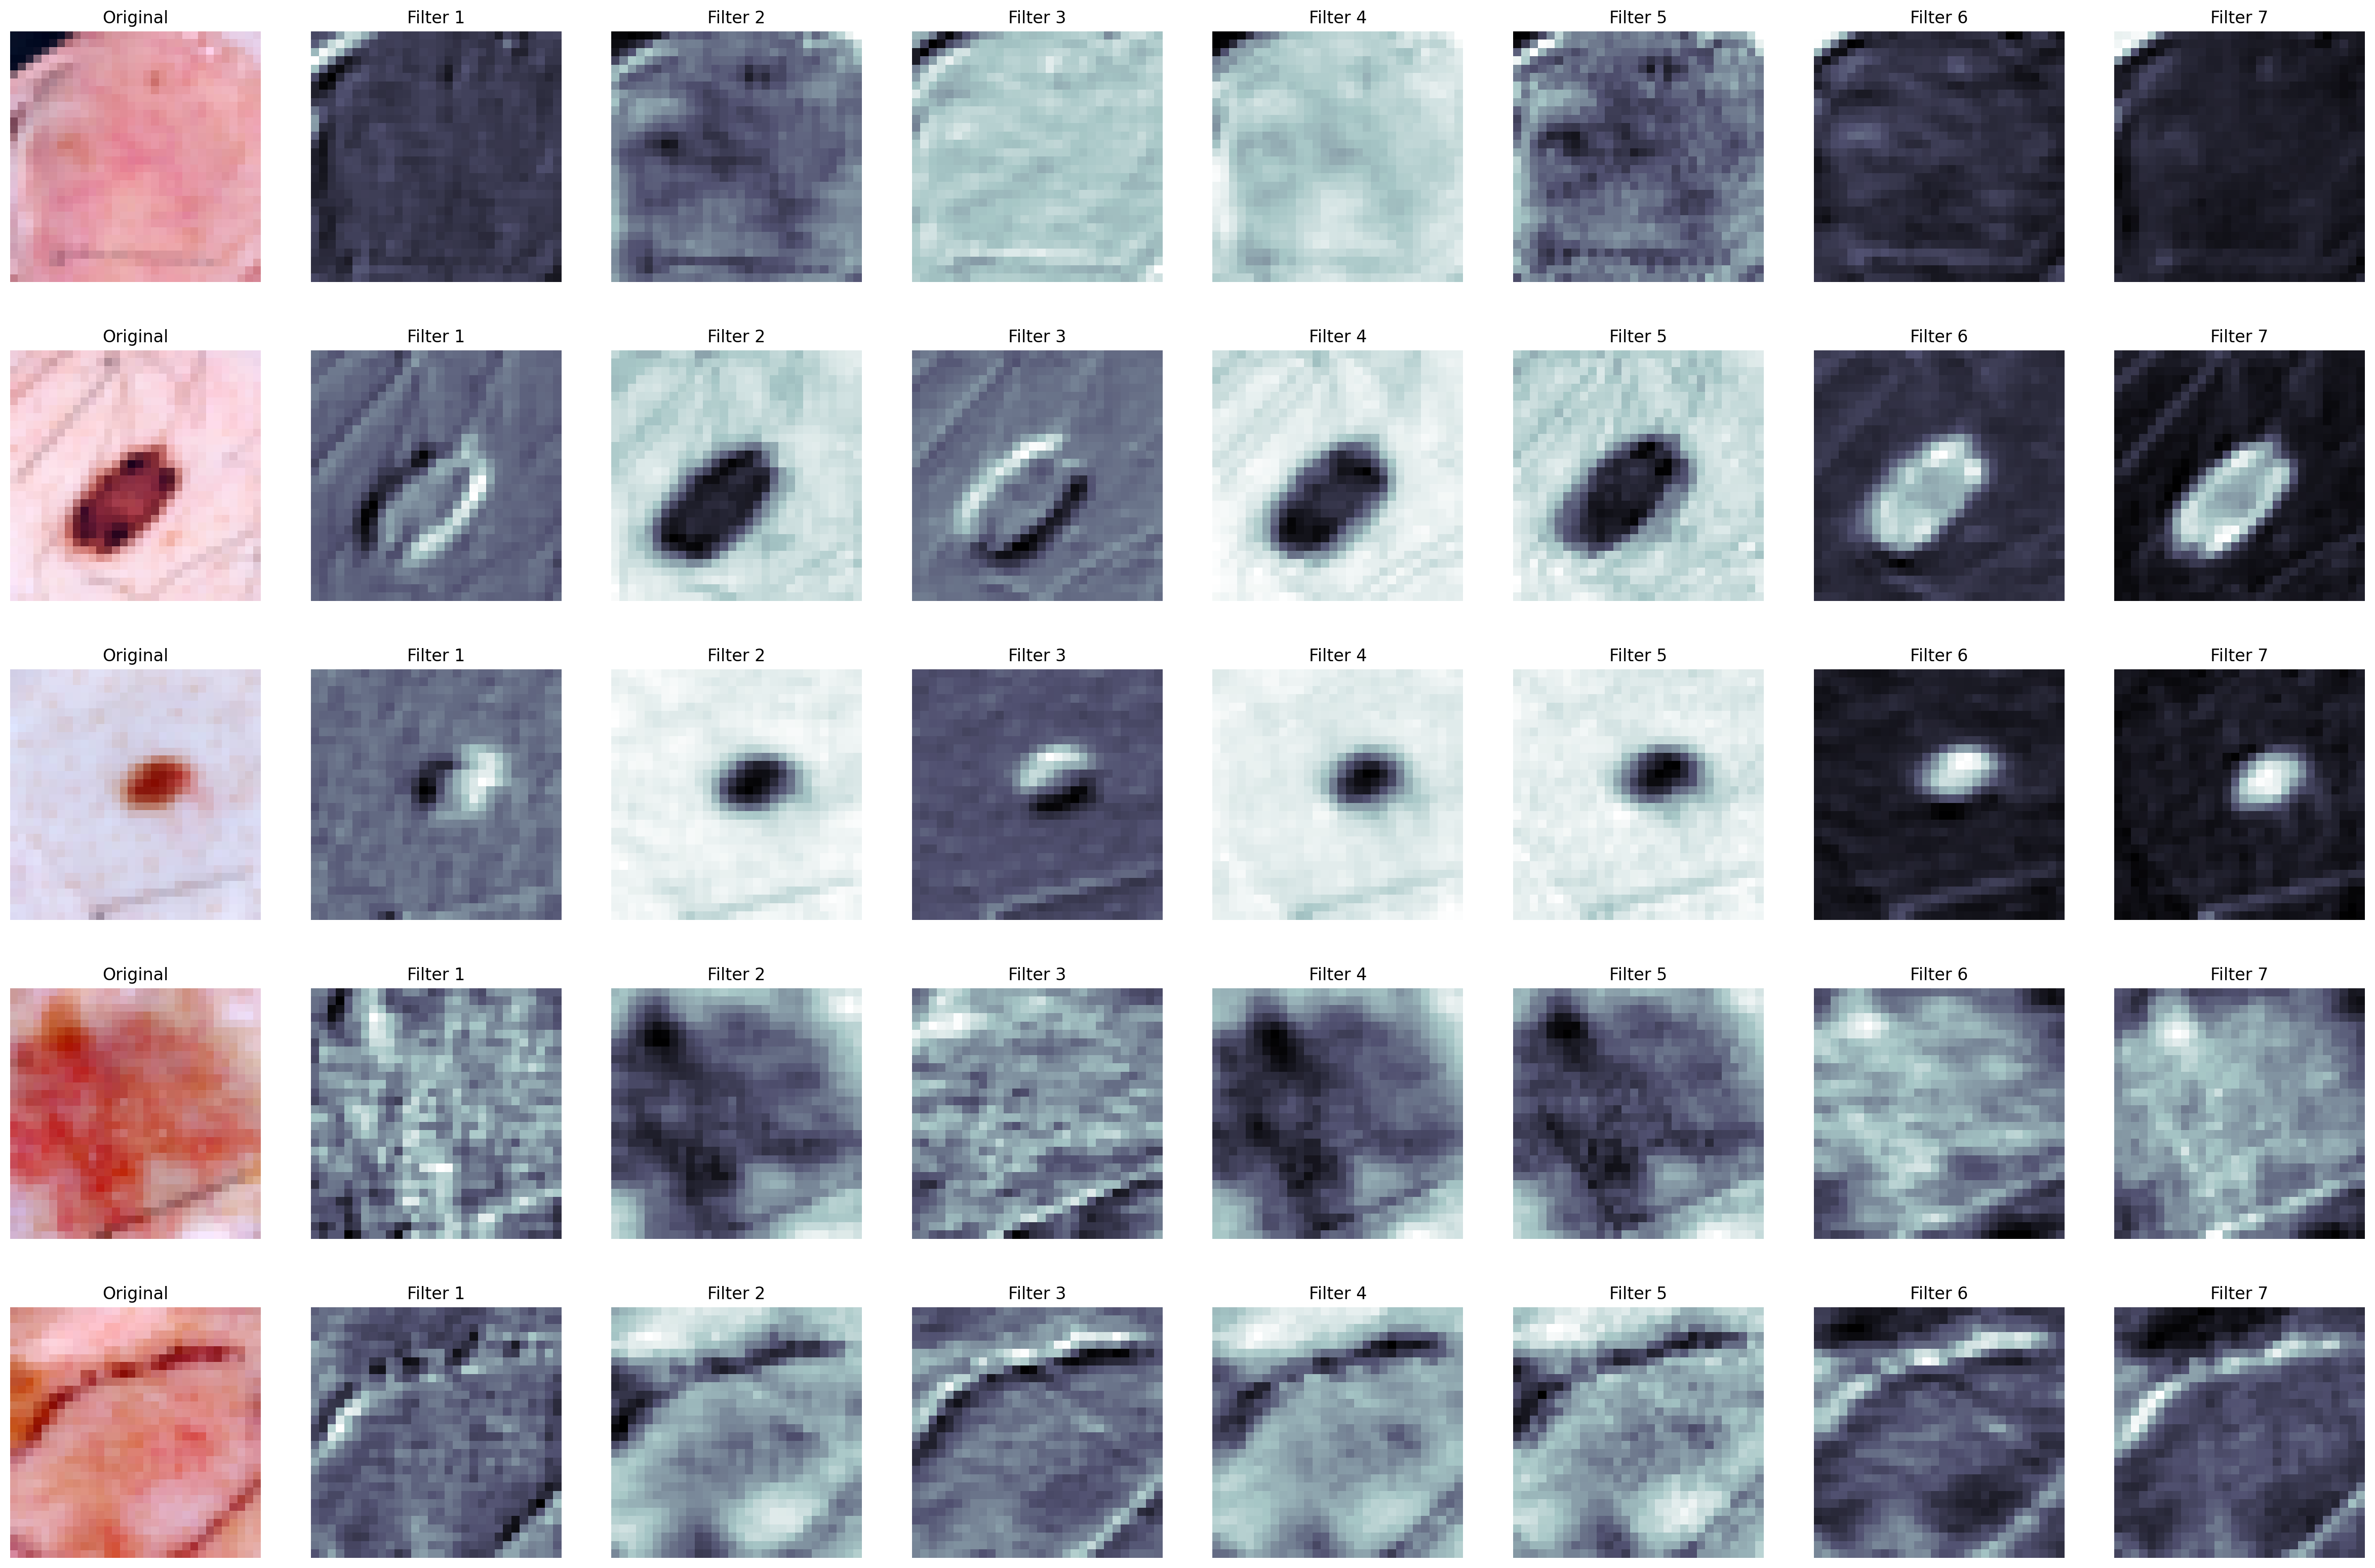

In [ ]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_ds[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [ ]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

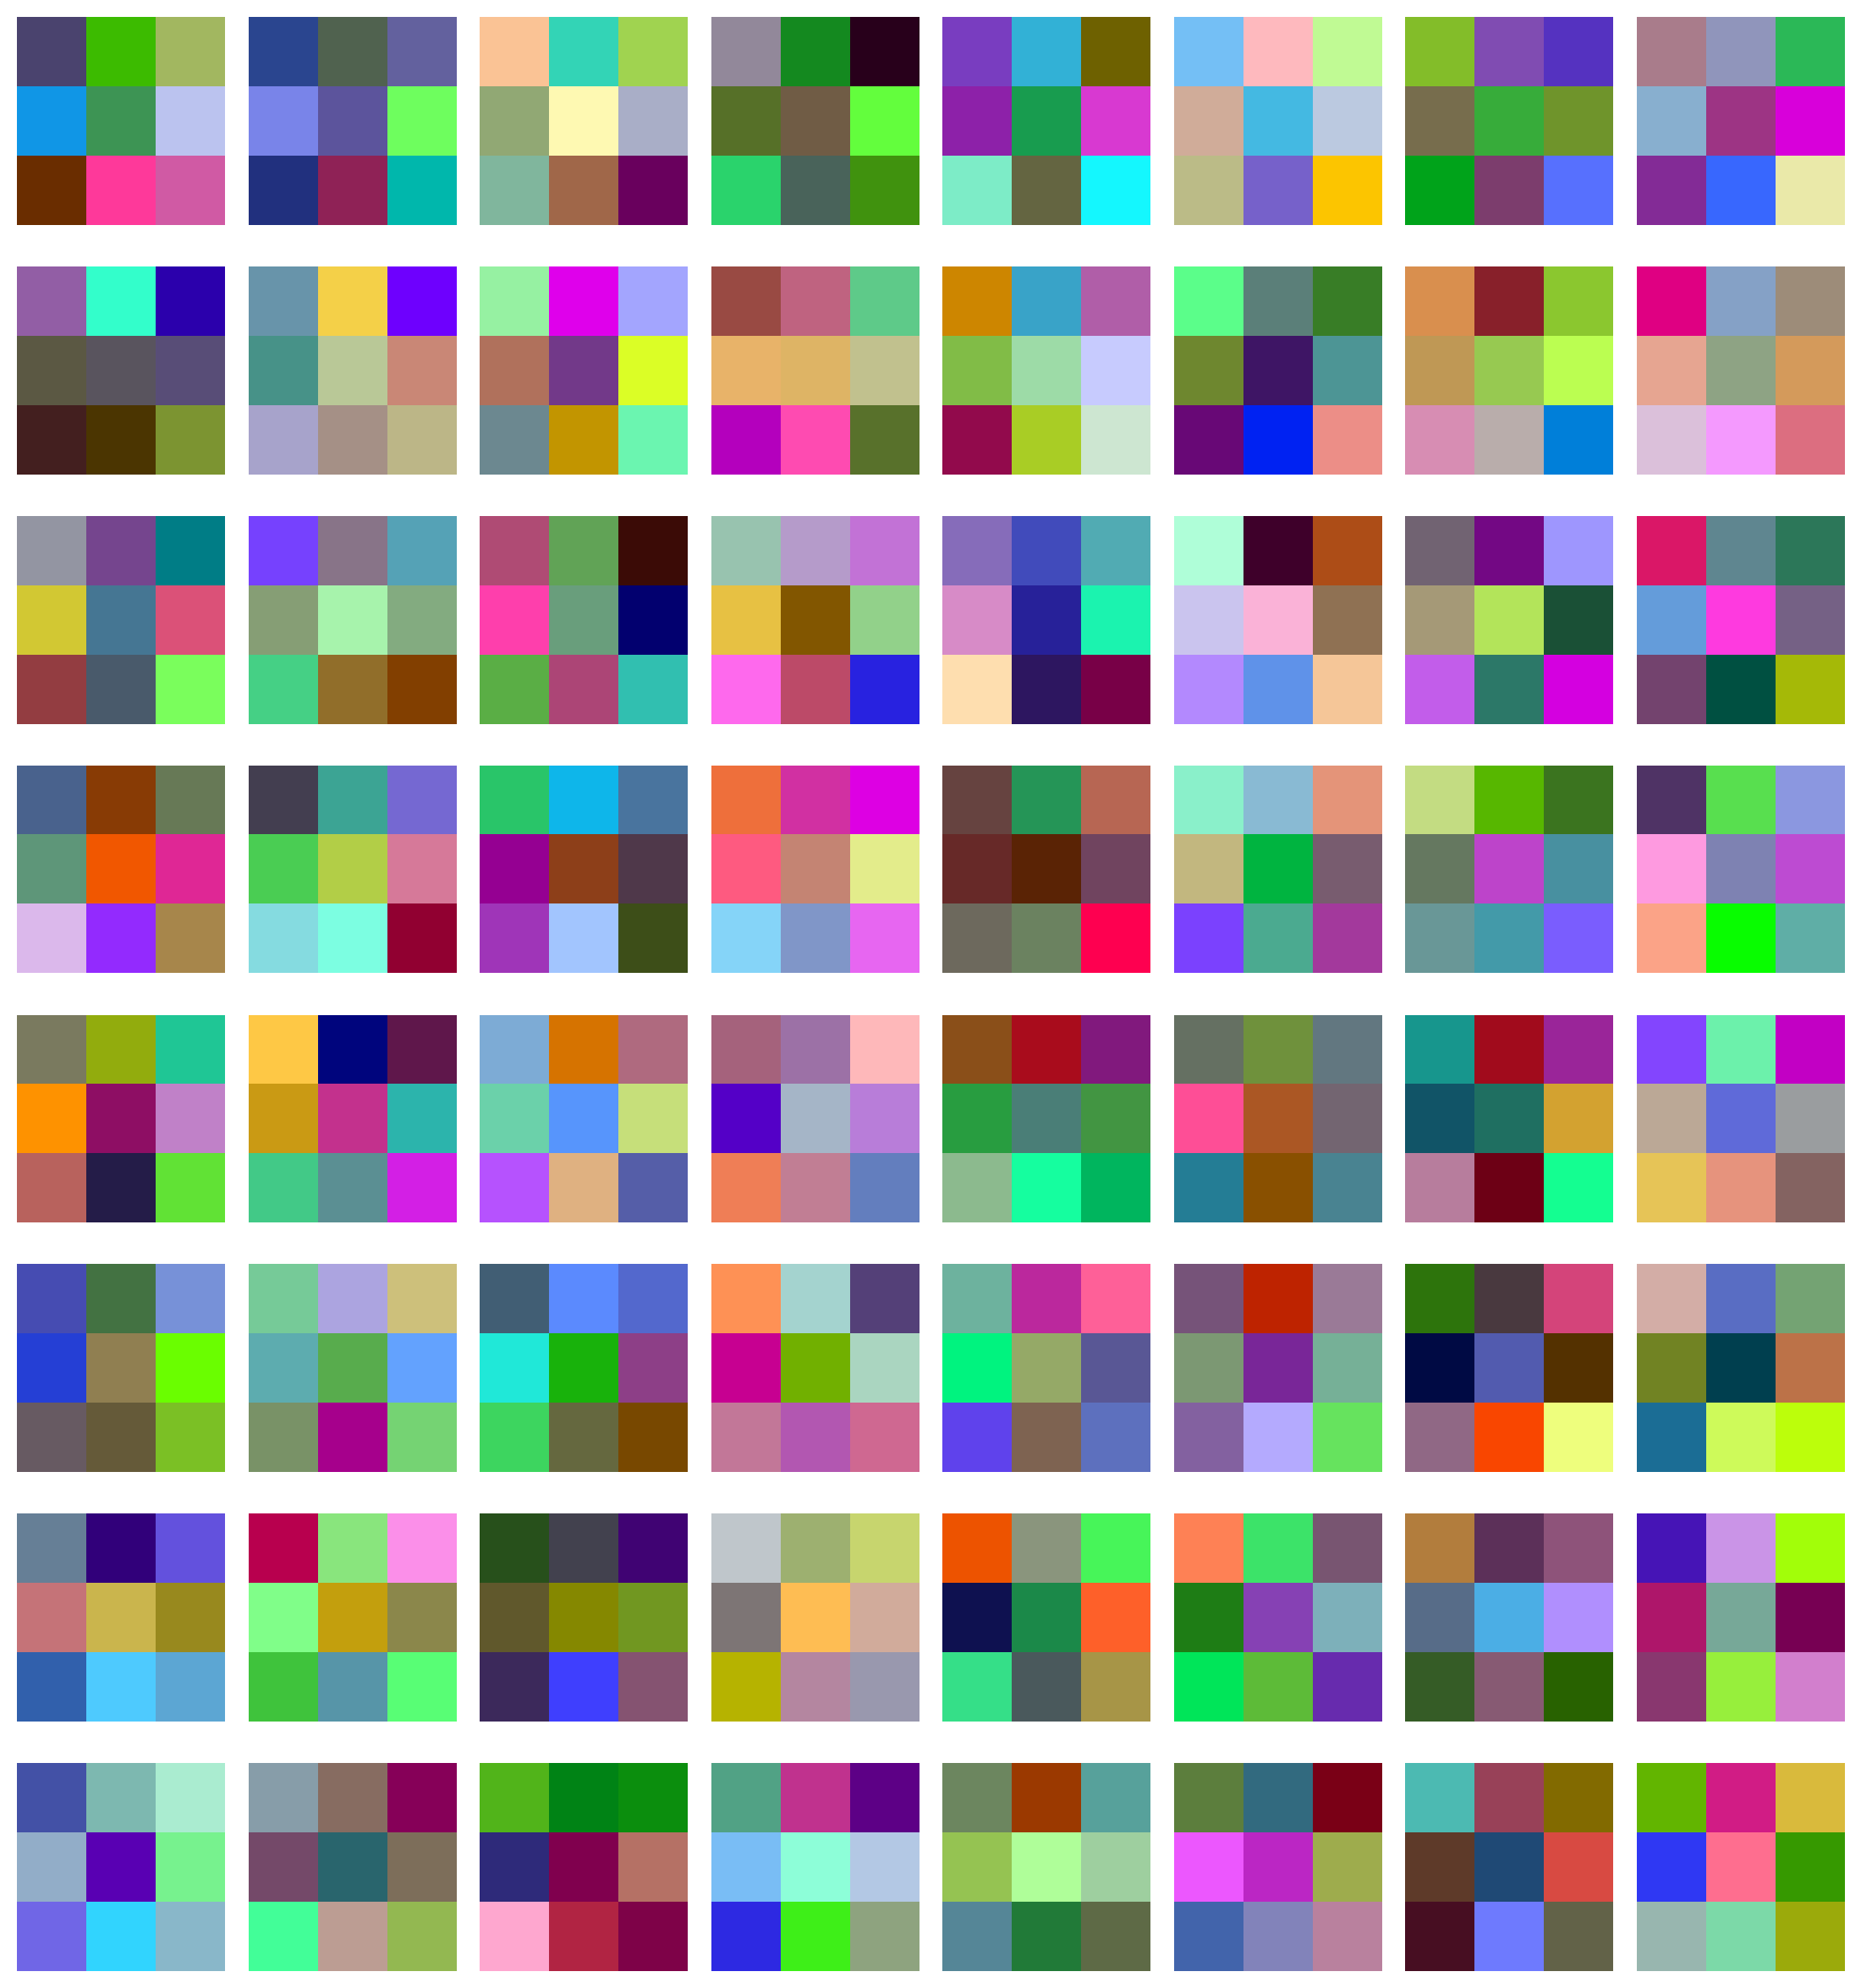

In [ ]:
plot_filters(filters)

The new Architecture


Calculating The output feature.

In [ ]:
image, labels = next(iter(train_iter))

In [ ]:
conv1 = nn.Conv2d(3, 32, 3, padding=1)
bn1 = nn.BatchNorm2d(32)
conv2 = nn.Conv2d(32, 64, 3, padding=1)
bn2 = nn.BatchNorm2d(64)
pool2 = nn.MaxPool2d(2,2)
conv3 = nn.Conv2d(64, 128, 3, padding=1)
bn3 = nn.BatchNorm2d(128)
conv4 = nn.Conv2d(128, 256, 3, padding=1)
bn4 = nn.BatchNorm2d(256)
pool4 = nn.MaxPool2d(2,2)
conv5 = nn.Conv2d(256, 512, 3, padding=1)
bn5 = nn.BatchNorm2d(512)
pool5 = nn.MaxPool2d(2,2)
flatten = nn.Flatten()

In [ ]:
print(image.shape)

torch.Size([32, 3, 32, 32])


In [ ]:
x = conv1(image)
print(x.shape)

torch.Size([32, 32, 32, 32])


In [ ]:
x = conv2(x)
print(x.shape)

torch.Size([32, 64, 32, 32])


In [ ]:
x = pool2(x)
print(x.shape)

torch.Size([32, 64, 16, 16])


In [ ]:
x = conv3(x)
print(x.shape)

torch.Size([32, 128, 16, 16])


In [ ]:
x = conv4(x)
print(x.shape)

torch.Size([32, 256, 16, 16])


In [ ]:
x = pool4(x)
print(x.shape)

torch.Size([32, 256, 8, 8])


In [ ]:
x = conv5(x)
print(x.shape)

torch.Size([32, 512, 8, 8])


In [ ]:
x = pool5(x)
print(x.shape)

torch.Size([32, 512, 4, 4])


In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Here's a breakdown of the layers:

Convolutional layer:

Input channels: 3 (RGB images)
Output channels: 64
Kernel size: 5x5
Padding: 2
Batch normalization layer:

Applies batch normalization to the output of the convolutional layer.
Flattening layer:

Reshapes the tensor to a 1-dimensional tensor, suitable for input to a fully connected layer.
Max pooling layer:

Performs max pooling with a kernel size of 2x2 and a stride of 2.
Dropout layer:

Randomly sets a fraction of input elements to 0 during training to prevent overfitting.
Fully connected layer:

Input features: 64 * 16 * 16 (output channels from the previous layer)
Output features: output_dim

SkinLesionNet version 1 with 1 layer

In [ ]:
class SkinLesionNet1(nn.Module):
    def __init__(self, output_dim):
        super(SkinLesionNet1, self).__init__()
        self.conv = nn.Conv2d(3, 64, 5, padding=2)
        self.bn = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 16 * 16, output_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)


def train_skin_lesion_model(train_iter, valid_iter, output_dim, device='cuda' if torch.cuda.is_available() else 'cpu', epochs=100):
    model = SkinLesionNet1(output_dim)
    model.apply(initialize_parameters)

    START_LR = 1e-7
    optimizer = optim.Adam(model.parameters(), lr=START_LR)
    criterion = nn.CrossEntropyLoss()

    model = model.to(device)
    criterion = criterion.to(device)

    STEPS_PER_EPOCH = len(train_iter)
    TOTAL_STEPS = epochs * STEPS_PER_EPOCH

    MAX_LRS = [p['lr'] for p in optimizer.param_groups]
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LRS, total_steps=TOTAL_STEPS)

    train_losses = []
    valid_losses = []

    best_valid_loss = float('inf')
    best_epoch = 0
    best_acc = 0.0

    for epoch in trange(epochs, desc="Epochs"):
        start_time = time.monotonic()

        train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
        valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            best_acc = valid_acc_1
            torch.save(model.state_dict(), 'best-model.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc_1 * 100:.2f}%')
        print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc_1 * 100:.2f}%')

    best_results = {'epoch': best_epoch + 1, 'accuracy': best_acc, 'loss': best_valid_loss}
    print(f'Best epoch: {best_results["epoch"]} | Accuracy: {best_results["accuracy"] * 100:.2f}% | Loss: {best_results["loss"]:.3f}')


In [ ]:
OUTPUT_DIM = 2  # Example output dimension
model = SkinLesionNet1(OUTPUT_DIM)
model.apply(initialize_parameters)
epochs = 10
train_skin_lesion_model(train_iter, valid_iter, OUTPUT_DIM, device, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'train' is not defined

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SkinLesionNet version 2 with 2 layers

In [ ]:
class SkinLesionNet2(nn.Module):
    def __init__(self, output_dim):
        super(SkinLesionNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 8 * 8, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x



def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)


def train_skin_lesion_model(train_iter, valid_iter, output_dim, device='cuda' if torch.cuda.is_available() else 'cpu', epochs=100):
    model = SkinLesionNet2(output_dim)
    model.apply(initialize_parameters)

    START_LR = 1e-7
    optimizer = optim.Adam(model.parameters(), lr=START_LR)
    criterion = nn.CrossEntropyLoss()

    model = model.to(device)
    criterion = criterion.to(device)

    STEPS_PER_EPOCH = len(train_iter)
    TOTAL_STEPS = epochs * STEPS_PER_EPOCH

    MAX_LRS = [p['lr'] for p in optimizer.param_groups]
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LRS, total_steps=TOTAL_STEPS)

    train_losses = []
    valid_losses = []

    best_valid_loss = float('inf')
    best_epoch = 0
    best_acc = 0.0

    for epoch in trange(epochs, desc="Epochs"):
        start_time = time.monotonic()

        train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
        valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            best_acc = valid_acc_1
            torch.save(model.state_dict(), 'best-model.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc_1 * 100:.2f}%')
        print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc_1 * 100:.2f}%')

    best_results = {'epoch': best_epoch + 1, 'accuracy': best_acc, 'loss': best_valid_loss}
    print(f'Best epoch: {best_results["epoch"]} | Accuracy: {best_results["accuracy"] * 100:.2f}% | Loss: {best_results["loss"]:.3f}')


In [ ]:
OUTPUT_DIM = 2  # Example output dimension
model = SkinLesionNet2(OUTPUT_DIM)
model.apply(initialize_parameters)
epochs = 10
train_skin_lesion_model(train_iter, valid_iter, OUTPUT_DIM, device, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 1.775 | Train Acc: 50.42%
	Val. Loss: 1.008 | Val. Acc: 46.36%
Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 1.756 | Train Acc: 50.20%
	Val. Loss: 0.998 | Val. Acc: 46.82%
Epoch: 03 | Epoch Time: 0m 37s
	Train Loss: 1.761 | Train Acc: 49.32%
	Val. Loss: 0.994 | Val. Acc: 46.77%
Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 1.742 | Train Acc: 49.86%
	Val. Loss: 0.958 | Val. Acc: 47.28%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 1.688 | Train Acc: 50.23%
	Val. Loss: 0.931 | Val. Acc: 47.90%
Epoch: 06 | Epoch Time: 0m 33s
	Train Loss: 1.702 | Train Acc: 49.85%
	Val. Loss: 0.908 | Val. Acc: 48.31%
Epoch: 07 | Epoch Time: 0m 40s
	Train Loss: 1.667 | Train Acc: 49.95%
	Val. Loss: 0.914 | Val. Acc: 48.46%
Epoch: 08 | Epoch Time: 0m 42s
	Train Loss: 1.658 | Train Acc: 50.98%
	Val. Loss: 0.894 | Val. Acc: 49.08%
Epoch: 09 | Epoch Time: 0m 44s
	Train Loss: 1.629 | Train Acc: 50.33%
	Val. Loss: 0.905 | Val. Acc: 48.62%
Epoch: 10 | Epoch Time: 0m 41s
	Train

In [ ]:
class SkinLesionNet(nn.Module):
    def __init__(self, output_dim):
        super(SkinLesionNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2,2)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 4 * 4, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool4(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.pool5(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.bn6(x)
        x = self.fc2(x)
        return x


In [ ]:
OUTPUT_DIM = 2

model = SkinLesionNet(OUTPUT_DIM)
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)


SkinLesionNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 100
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 100  # You may need to run longer to get better results. Lab example is for demo only

# Keeping track of losses
train_losses = []
valid_losses = []

best_valid_loss = float('inf')
best_epoch = 0
best_acc = 0.0

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        best_acc = valid_acc_1
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc_1 * 100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc_1 * 100:.2f}%')

best_results = {'epoch': best_epoch + 1, 'accuracy': best_acc, 'loss': best_valid_loss}
print(f'Best epoch: {best_results["epoch"]} | Accuracy: {best_results["accuracy"] * 100:.2f}% | Loss: {best_results["loss"]:.3f}')


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 23s
	Train Loss: 1.367 | Train Acc: 45.77%
	Val. Loss: 1.058 | Val. Acc: 44.67%
Epoch: 02 | Epoch Time: 1m 22s
	Train Loss: 1.383 | Train Acc: 45.29%
	Val. Loss: 1.049 | Val. Acc: 45.85%
Epoch: 03 | Epoch Time: 1m 22s
	Train Loss: 1.342 | Train Acc: 47.16%
	Val. Loss: 1.039 | Val. Acc: 45.59%
Epoch: 04 | Epoch Time: 1m 23s
	Train Loss: 1.333 | Train Acc: 47.54%
	Val. Loss: 1.015 | Val. Acc: 46.77%
Epoch: 05 | Epoch Time: 1m 24s
	Train Loss: 1.351 | Train Acc: 47.53%
	Val. Loss: 1.013 | Val. Acc: 46.47%
Epoch: 06 | Epoch Time: 1m 25s
	Train Loss: 1.313 | Train Acc: 48.27%
	Val. Loss: 1.001 | Val. Acc: 46.52%
Epoch: 07 | Epoch Time: 1m 23s
	Train Loss: 1.304 | Train Acc: 48.49%
	Val. Loss: 0.999 | Val. Acc: 47.03%
Epoch: 08 | Epoch Time: 1m 25s
	Train Loss: 1.295 | Train Acc: 47.98%
	Val. Loss: 0.957 | Val. Acc: 48.62%
Epoch: 09 | Epoch Time: 1m 23s
	Train Loss: 1.258 | Train Acc: 50.01%
	Val. Loss: 0.947 | Val. Acc: 50.00%
Epoch: 10 | Epoch Time: 1m 24s
	Train

In [ ]:
best_valid_loss = float('inf')
patience = 5  # number of epochs to wait for improvement
wait = 0  # number of epochs waited for improvement

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        wait = 0  # reset wait counter
        torch.save(model.state_dict(), 'Dimzynet.pt')
    else:
        wait += 1
        if wait >= patience:
            print(f'No improvement for {patience} epochs, stopping training...')
            break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% ')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% ')
    print(wait)



Epoch: 01 | Epoch Time: 1m 27s
	Train Loss: 1.335 | Train Acc @1:  46.44% 
	Valid Loss: 1.037 | Valid Acc @1:  45.03% 
0
Epoch: 02 | Epoch Time: 1m 23s
	Train Loss: 1.359 | Train Acc @1:  46.61% 
	Valid Loss: 1.020 | Valid Acc @1:  45.95% 
0
Epoch: 03 | Epoch Time: 1m 23s
	Train Loss: 1.339 | Train Acc @1:  47.59% 
	Valid Loss: 1.004 | Valid Acc @1:  46.93% 
0
Epoch: 04 | Epoch Time: 1m 28s
	Train Loss: 1.321 | Train Acc @1:  47.67% 
	Valid Loss: 1.002 | Valid Acc @1:  46.88% 
0
Epoch: 05 | Epoch Time: 1m 15s
	Train Loss: 1.305 | Train Acc @1:  48.43% 
	Valid Loss: 1.002 | Valid Acc @1:  46.77% 
1
Epoch: 06 | Epoch Time: 1m 26s
	Train Loss: 1.293 | Train Acc @1:  48.62% 
	Valid Loss: 0.970 | Valid Acc @1:  48.57% 
0
Epoch: 07 | Epoch Time: 1m 31s
	Train Loss: 1.276 | Train Acc @1:  48.72% 
	Valid Loss: 0.951 | Valid Acc @1:  49.49% 
0
Epoch: 08 | Epoch Time: 1m 25s
	Train Loss: 1.240 | Train Acc @1:  49.77% 
	Valid Loss: 0.910 | Valid Acc @1:  51.54% 
0
Epoch: 09 | Epoch Time: 1m 31s
	

In [ ]:
best_valid_loss

0.5918380571681945

In [ ]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    preds = []

    with torch.no_grad():
        for batch in iterator:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)  # Modify this line to capture all the model outputs

            if isinstance(outputs, tuple):
                # If the model returns a tuple, assume the first value is the prediction
                y_pred = outputs[0]
            else:
                # If the model returns a single output, consider it as the prediction
                y_pred = outputs

            images.append(x)
            labels.append(y)
            preds.append(y_pred)

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    preds = torch.cat(preds, dim=0)

    return images, labels, preds


In [ ]:
model.load_state_dict(torch.load('best-model.pt'))
images, labels, probs = get_predictions(model, test_iter, device)

In [ ]:


test = pd.read_csv('/Users/macbook/Downloads/ISIC_balanced_split/ISIC2017_Test_GroundTruth.csv')
y_test = np.array(test.drop(['id'], axis=1))

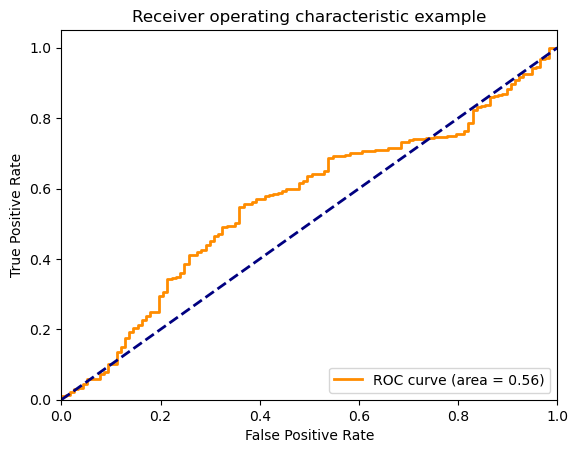

/var/folders/d9/1sn3xmzd49v653mvdfkrs_f80000gn/T/ipykernel_21764/2748991758.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


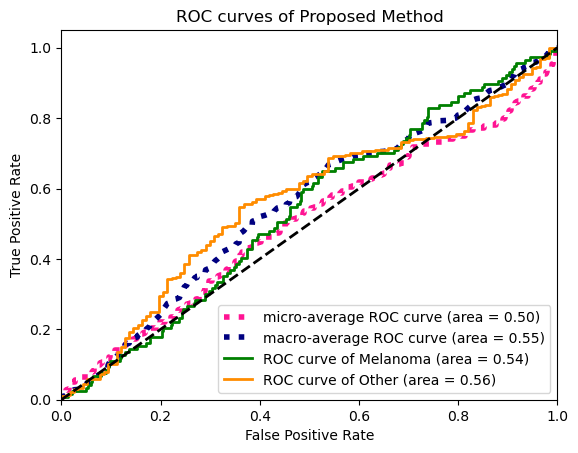

[[ 76  41]
 [238 245]]
[0 1]
[117 483]
[[117. 117.]
 [483. 483.]]
              precision    recall  f1-score   support

           0       0.24      0.65      0.35       117
           1       0.86      0.51      0.64       483

    accuracy                           0.54       600
   macro avg       0.55      0.58      0.49       600
weighted avg       0.74      0.54      0.58       600



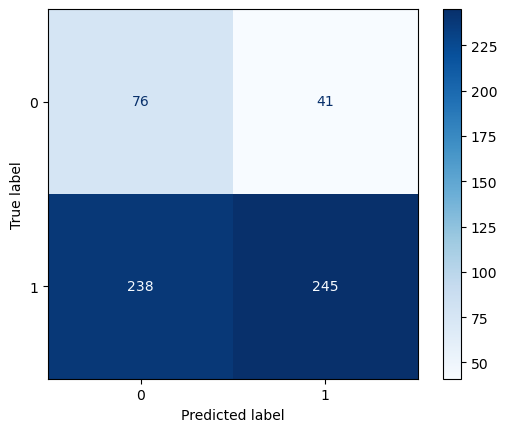

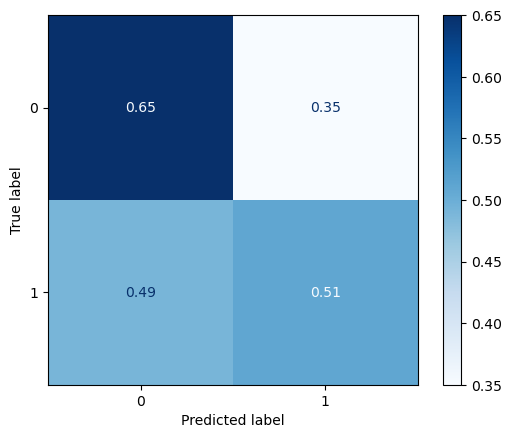

In [ ]:

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
#change to OneVsOneClassifier for generalized AUC
#from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of Melanoma (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of Other (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
# plt.plot(fpr[2], tpr[2], color='red', lw=lw,
#          label='ROC curve of third class (area = {1:0.2f})'
#          ''.format(1, roc_auc[2]))

# plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
#          label='ROC curve of fourth class (area = {1:0.2f})'
#          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((2,2))
divisor[0][:] = 117
divisor[1][:] = 483
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')
from sklearn.metrics import classification_report
print(classification_report(true_class, pred_class))